In [40]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import numpy as np
from collections import defaultdict, deque
import time
import os
import json
from itertools import permutations, islice

In [41]:
tasks = ['A', 'B', 'C', 'D', 'E']
edges = [('A', 'B'), ('A', 'C'), ('B', 'D'), ('C', 'D'), ('D', 'E')]
delays = {'A': 1, 'B': 1, 'C': 4, 'D': 1, 'E': 3}

In [42]:
class Individual:
    def __init__(self, schedule, edges, delay):
        self.schedule = schedule
        self.fitness = self.calc_fitness(edges, delay)

    #ako ne zadovoljava topsort fitness->inf inace izracunaj max(S)
    def calc_fitness(self, edges, delay):
        if not is_valid_schedule(self.schedule, edges):
            return float('-inf')
        graph, predak = inicialize_graph(edges)
        return -calculate_S(self.schedule, graph, delay, predak)[1]

    def invert(self):
        idx1, idx2 = random.sample(range(len(self.schedule)), 2)
        self.schedule[idx1], self.schedule[idx2] = self.schedule[idx2], self.schedule[idx1]
        return idx1, idx2
            
    def __lt__(self, other):
        return self.fitness < other.fitness

In [43]:
def is_valid_schedule(schedule, edges):
    """Check if the schedule respects the precedence constraints."""
    task_to_index = {task: index for index, task in enumerate(schedule)}
    for u, v in edges:
        if task_to_index[u] > task_to_index[v]:
            return False
    return True

In [44]:
def inicialize_graph(edges):
    graph = defaultdict(list)
    predak = defaultdict(list)

    for u, v in edges:
        graph[u].append(v)
        predak[v].append(u)

    return graph, predak

In [45]:
def calculate_S(permutation, graph, delay, predak):
    S = {t: 0 for t in permutation}
    for node in permutation:
        max_S = S[node]
        for prec in predak[node]:
            max_S = max(S[node], S[prec] + delay[prec] + 1)

        #ako postoji node sa istim S, uvecamo ga za 1
        while max_S in S.values():
            max_S += 1
        S[node] = max_S

    return S, max(S.values())

In [46]:
def create_initial_population(size_of_population, tasks, edges, delays):
    population = [] 
    selected_permutations = list(islice(permutations(tasks), size_of_population))
    random.shuffle(selected_permutations)
    
    for schedule in selected_permutations:
        individual = Individual(list(schedule), edges, delays)
        population.append(individual)
        
    return population

In [47]:
def selection(population, tournament_size):
    chosen = random.sample(population, tournament_size)
    return max(chosen)

In [48]:
def crossover(parent1, parent2):
    """Perform crossover between two parents to create a child."""
    idx1, idx2 = sorted(random.sample(range(len(parent1.schedule)), 2))
    child = [None] * len(parent1.schedule)
    child[idx1:idx2+1] = parent1.schedule[idx1:idx2+1]
    
    current_pos = 0
    for task in parent2.schedule:
        if task not in child:
            while child[current_pos] is not None:
                current_pos += 1
            child[current_pos] = task
    return child

In [49]:
def mutate(individual):
    """Perform mutation by swapping two random tasks."""
    idx1, idx2 = random.sample(range(len(individual)), 2)
    individual[idx1], individual[idx2] = individual[idx2], individual[idx1]

In [53]:
def simulatedAnnealing(individual, tasks, edges, delays, iters):
    for i in range(1, iters+1):
        # promeni malo individual
        idx1, idx2 = individual.invert()
        new_fitness= individual.calc_fitness(edges, delays)
        if new_fitness > individual.fitness:
            individual.fitness = new_fitness
        else:
            p = 1.0 / i ** 0.5
            q = random.uniform(0, 1)
            if p > q:
                individual.fitness = new_fitness
            else:                
                # vrati se na prethodno i nastavi odatle
                individual.schedule[idx2], individual.schedule[idx1] = individual.schedule[idx1], individual.schedule[idx2]

In [54]:
def genetic_algorithm(population_size, num_generations, 
                      tournament_size, elitism_size, mutation_prob,
                     tasks, edges, delays):
    population = create_initial_population(population_size, tasks, edges, delays)
    new_population = []
    start_time = time.time()
    
    for i in range(num_generations):
        population = sorted(population, reverse=True)
        new_population[:elitism_size] = population[:elitism_size]
        for j in range(elitism_size, population_size):
            parent1 = selection(population, tournament_size)#nz dal se razlikuju
            parent2 = selection(population, tournament_size)

            child_schedule = crossover(parent1, parent2)
            
            if random.random() < mutation_prob:
                mutate(child_schedule)
                
            new_population.append(Individual(child_schedule, edges, delays))

        simulatedAnnealing(max(new_population), tasks, edges, delays, iters=10)
        population = new_population.copy()
        
    end_time = time.time()
    time_taken = end_time - start_time
    best_individual = max(population)
    print(f'solution: {best_individual.schedule}, cost: {-best_individual.fitness}, time taken: {time_taken}')
    return best_individual.schedule, -best_individual.fitness, time_taken

In [55]:
# Run the genetic algorithm
order, cost, time_taken = genetic_algorithm(  population_size=100, 
                    num_generations=50, 
                    tournament_size=7,
                    elitism_size=3,
                    mutation_prob=0.1,
                    tasks=tasks, edges=edges, delays=delays)


solution: ['A', 'C', 'B', 'D', 'E'], cost: 10, time taken: 0.22086477279663086


In [56]:
def draw_graph(tasks, edges, delays):
    G = nx.DiGraph()
    
    G.add_nodes_from(tasks)
    
    # Add edges with weights (delays)
    G.add_edges_from(edges)
    
    # Define positions for nodes using a layout
    pos = nx.spring_layout(G)
    
    # Draw the graph
    nx.draw(G, pos, with_labels=True, node_color='lightgreen', node_size=3000, font_size=16, font_color='black', arrowstyle='-|>', arrowsize=20)
    
    # Draw the delays as separate text next to the nodes
    for node, (x, y) in pos.items():
        plt.text(x + 0.09, y - 0.075, s=f"Delay: {delays[node]}", bbox=dict(facecolor='white', alpha=0.5), horizontalalignment='center', fontsize=12, color='blue')
    
    # Show the plot
    plt.show()

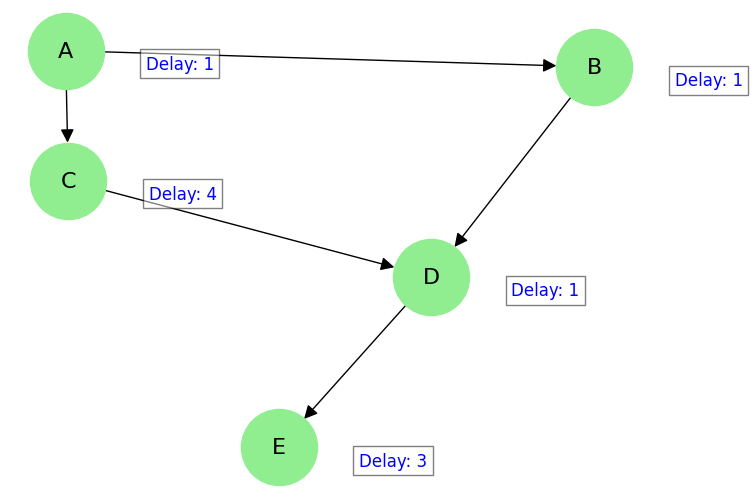

In [57]:
draw_graph(tasks, edges, delays)

In [58]:
def save_results(file, data):
    with open(file, 'w') as file:
        json.dump(data, file, indent=4)
    print(f"Data saved to {file}")

In [59]:
def test_alg(path_to_test, path_to_results, big_data): 
    files = os.listdir(path_to_test)
    data_files = [f for f in files if f.startswith('test_file_') and f.endswith('.json')]
    data_to_write = []

    for file_name in data_files:
        file_path = os.path.join(path_to_test, file_name)
        with open(file_path, 'r') as f:
            loaded_data = json.load(f)
            tasks = loaded_data.get('tasks')
            edges = loaded_data.get('edges')
            delays = loaded_data.get('delays')

            #small_data
            if(not big_data):
                order, cost, time_taken = genetic_algorithm(population_size=100, 
                                                            num_generations=50, 
                                                            tournament_size=20,
                                                            elitism_size=3,
                                                            mutation_prob=0.2,
                                                            tasks= tasks,
                                                            edges=edges,
                                                            delays=delays)
            else:
                order, cost, time_taken = genetic_algorithm(population_size=100, 
                                                            num_generations=50, 
                                                            tournament_size=50,
                                                            elitism_size=3,
                                                            mutation_prob=0.2,
                                                            tasks= tasks,
                                                            edges=edges,
                                                            delays=delays)
            draw_graph(tasks, edges, delays)
            print("----------------------------------------------")
            data = {
            'test_name' : file_name,
            'order_of_tasks': order,
            'finish_time': cost,
            'time_taken': time_taken
            }
            data_to_write.append(data)
    
    save_results(path_to_results, data_to_write)

## Test on small data

solution: ['D', 'A', 'B', 'C', 'E'], cost: 10, time taken: 0.29124927520751953


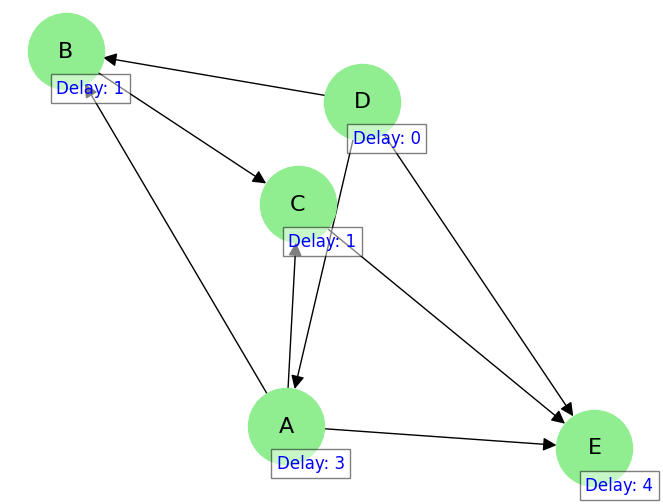

----------------------------------------------
solution: ['E', 'F', 'B', 'D', 'A', 'C'], cost: 15, time taken: 0.22043466567993164


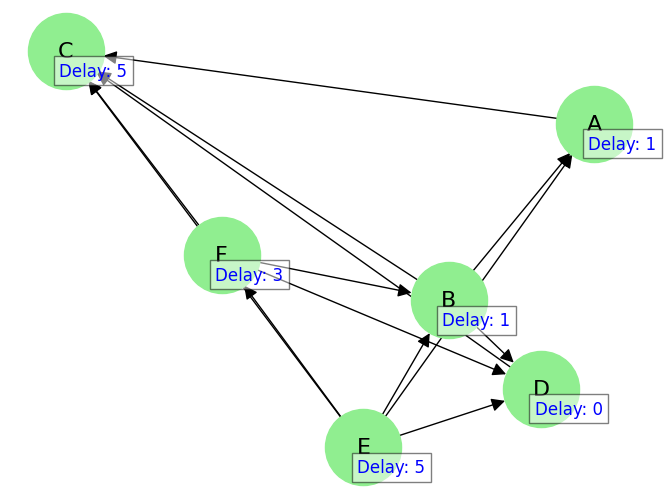

----------------------------------------------
solution: ['G', 'C', 'E', 'D', 'A', 'B', 'F'], cost: 23, time taken: 0.22539591789245605


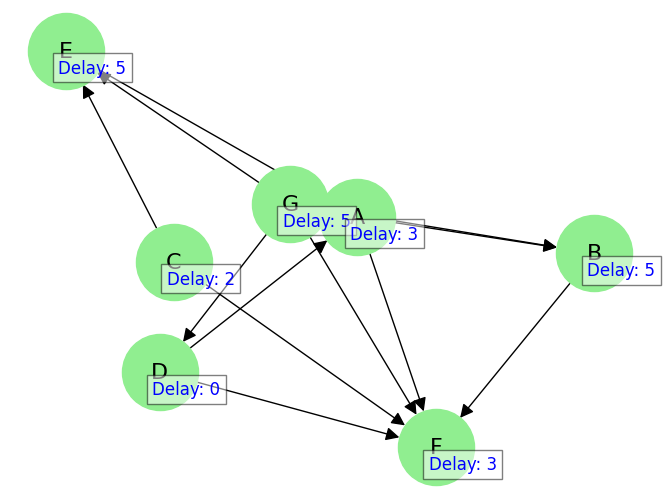

----------------------------------------------
solution: ['B', 'G', 'C', 'F', 'D', 'A', 'E', 'H'], cost: 22, time taken: 0.23138213157653809


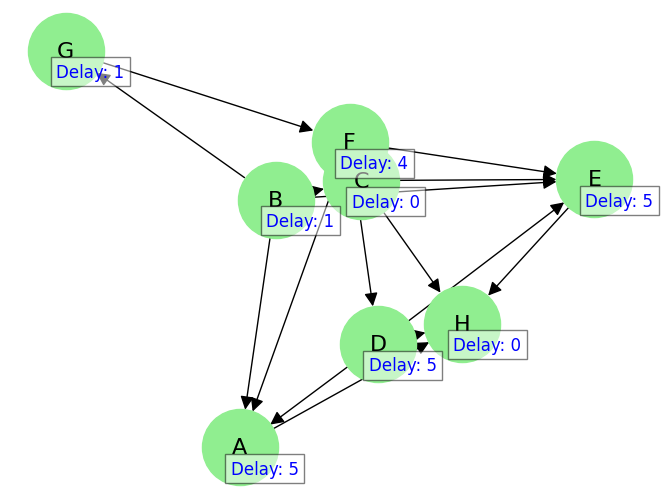

----------------------------------------------
solution: ['C', 'A', 'B', 'E', 'F', 'G', 'H', 'D', 'I'], cost: 15, time taken: 0.24235296249389648


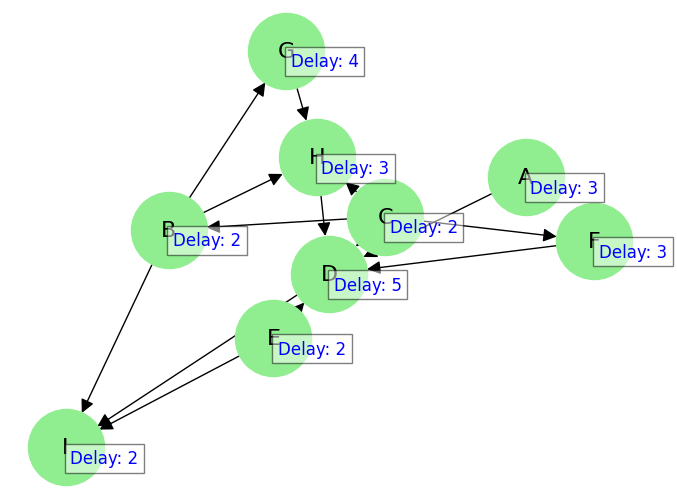

----------------------------------------------
Data saved to <_io.TextIOWrapper name='results/small_data/GASA.json' mode='w' encoding='cp1252'>


In [61]:
test_file = 'test_files/small_data/'
result_file = 'results/small_data/GASA.json'
test_alg(test_file, result_file, False)

## Test on big data

solution: ['K', 'N', 'P', 'B', 'I', 'M', 'O', 'A', 'Q', 'F', 'T', 'H', 'E', 'D', 'J', 'L', 'S', 'G', 'R', 'C'], cost: 60, time taken: 0.4338676929473877


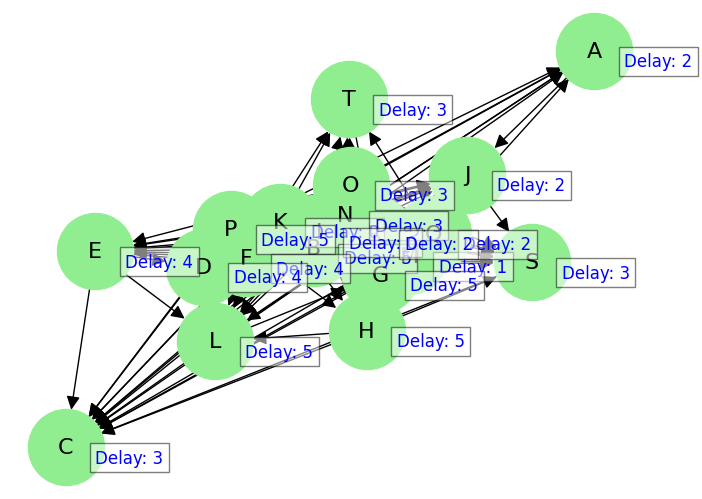

----------------------------------------------
solution: ['U', 'P', 'L', 'O', 'A', 'H', 'N', 'K', 'E', 'D', 'J', 'R', 'B', 'I', 'T', 'S', 'F', 'M', 'Q', 'G', 'C'], cost: 43, time taken: 0.45980215072631836


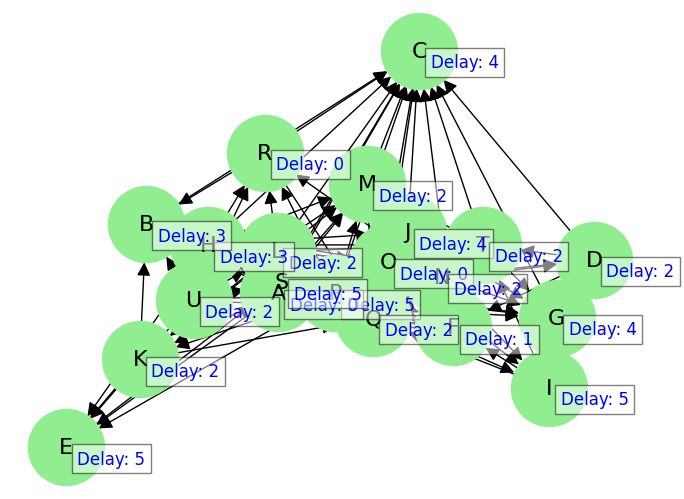

----------------------------------------------
solution: ['P', 'U', 'V', 'K', 'N', 'R', 'I', 'S', 'F', 'O', 'J', 'Q', 'B', 'H', 'D', 'A', 'E', 'T', 'L', 'M', 'G', 'C'], cost: 40, time taken: 0.44885802268981934


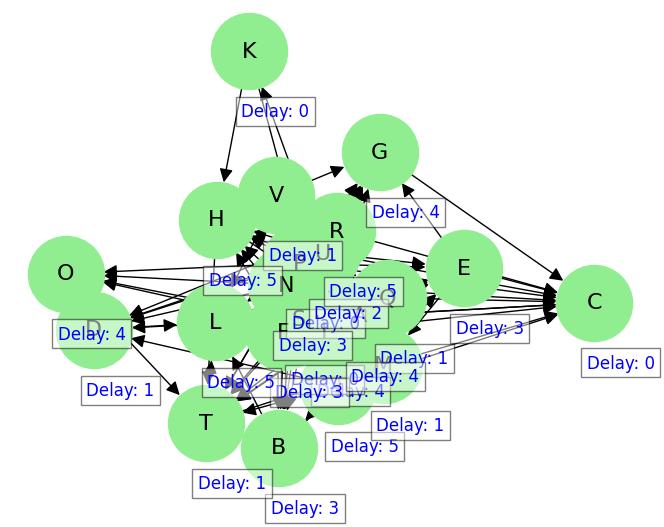

----------------------------------------------
solution: ['G', 'U', 'H', 'D', 'R', 'F', 'E', 'I', 'K', 'W', 'J', 'L', 'P', 'M', 'S', 'O', 'Q', 'B', 'V', 'N', 'T', 'C', 'A'], cost: 51, time taken: 0.472858190536499


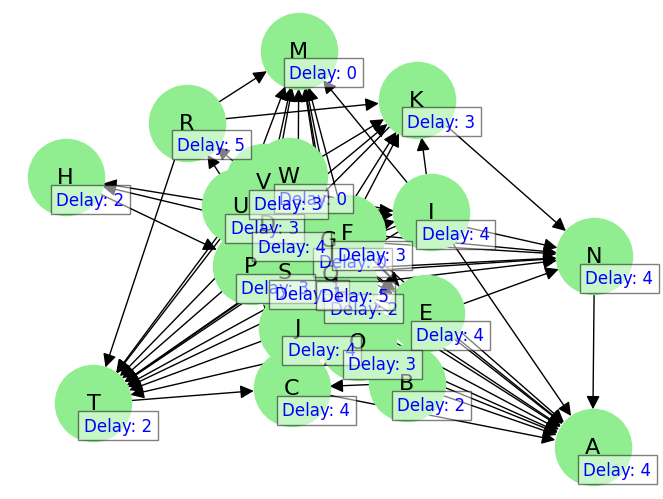

----------------------------------------------
solution: ['E', 'F', 'U', 'H', 'D', 'A', 'R', 'G', 'I', 'M', 'V', 'S', 'X', 'B', 'P', 'O', 'J', 'C', 'W', 'Q', 'T', 'N', 'L', 'K'], cost: 49, time taken: 0.48273611068725586


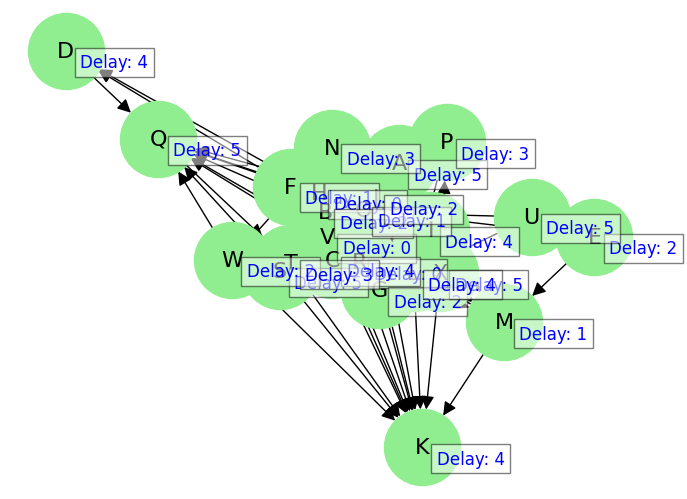

----------------------------------------------
solution: ['B', 'M', 'I', 'J', 'R', 'P', 'U', 'N', 'W', 'O', 'E', 'X', 'G', 'T', 'Y', 'V', 'K', 'C', 'H', 'S', 'Q', 'A', 'L', 'D', 'F'], cost: 44, time taken: 0.5206372737884521


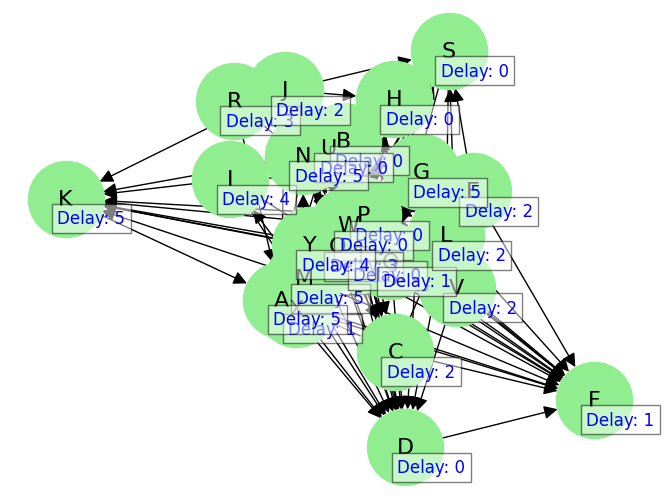

----------------------------------------------
Data saved to <_io.TextIOWrapper name='results/big_data/GASA.json' mode='w' encoding='cp1252'>


In [62]:
test_file = 'test_files/big_data/'
result_file = 'results/big_data/GASA.json'
test_alg(test_file, result_file, False)